## Spatial Query of GLA06 Data for Greenland

Because of the large volume of data, the GLA06 data were imported using a separate table for each laser epoch.  For this project I'm just interested in Greenland data so I've copied the data into a single table, `gla06_034_grn`.  I've also converted the geometry field from the original lat-lon to EPSG:3413 (north polar stereo).

To make it even easier I'm just starting with a box in PS coords.

In [1]:
# just use some python to create a bounding box string
jak_bbox=(-212483.24,-2334797.72,-57857.51,-2209489.29)

psx_ll, psy_ll, psx_ur, psy_ur = jak_bbox

          
coords = "{0} {1},".format(psx_ll, psy_ll) + \
    "{0} {1},".format(psx_ll, psy_ur) + \
    "{0} {1},".format(psx_ur, psy_ur) + \
    "{0} {1},".format(psx_ur, psy_ll) + \
    "{0} {1}".format(psx_ll, psy_ll)
    
bbox = "ST_MakePolygon(ST_GeomFromText('LINESTRING({0})',3413))".format(coords)
print bbox

ST_MakePolygon(ST_GeomFromText('LINESTRING(-212483.24 -2334797.72,-212483.24 -2209489.29,-57857.51 -2209489.29,-57857.51 -2334797.72,-212483.24 -2334797.72)',3413))


Given this polygon the SQL query to extract the point would be something like the following:

    select count(*) from gla06_034_grn where
    ST_Contains(ST_MakePolygon(ST_GeomFromText(
    'LINESTRING(-212483.24 -2334797.72,-212483.24 -2209489.29,-57857.51 
    -2209489.29,-57857.51 -2334797.72,-212483.24 -2334797.72)',3413)),
    the_geom);
    
The `gla06_034_grn` table has 45,685,416 rows.  This query took about 40 seconds and returned 86,889 rows.  Note this is a rather large box just east of the Jakobshavn Fjord.  Find the middle point then create a smaller box (10km x 10km) and retry query.  

In [13]:
cntr_x = jak_bbox[0] + (jak_bbox[2] - jak_bbox[0])/2.
cntr_y = jak_bbox[1] + (jak_bbox[3] - jak_bbox[1])/2.
print cntr_x, cntr_y

# for GLAS06 data try a grid size of 20km
grid_xsize = 10000.
grid_ysize = grid_xsize
grid_dx = grid_xsize / 2.
grid_dy = grid_ysize / 2.
jak_bbox = [cntr_x - grid_dx, cntr_y - grid_dy, cntr_x + grid_dx, cntr_y + grid_dy]

psx_ll, psy_ll, psx_ur, psy_ur = jak_bbox

# shift 

coords = "{0} {1},".format(psx_ll, psy_ll) + \
    "{0} {1},".format(psx_ll, psy_ur) + \
    "{0} {1},".format(psx_ur, psy_ur) + \
    "{0} {1},".format(psx_ur, psy_ll) + \
    "{0} {1}".format(psx_ll, psy_ll)
  
bbox = "ST_MakePolygon(ST_GeomFromText('LINESTRING({0})',3413))".format(coords)
print bbox
query = "select count(*) from gla06_034_grn where ST_Contains({0},the_geom);"
query = query.format(bbox)
print query

-135170.375 -2272143.505
ST_MakePolygon(ST_GeomFromText('LINESTRING(-140170.375 -2277143.505,-140170.375 -2267143.505,-130170.375 -2267143.505,-130170.375 -2277143.505,-140170.375 -2277143.505)',3413))
select count(*) from gla06_034_grn where ST_Contains(ST_MakePolygon(ST_GeomFromText('LINESTRING(-140170.375 -2277143.505,-140170.375 -2267143.505,-130170.375 -2267143.505,-130170.375 -2277143.505,-140170.375 -2277143.505)',3413)),the_geom);


This query resulted in 431 rows returned. 

Our goal is to difference the surface elevation from each of these 431 shots with the GIMP DEM elevation at that location AND come up with a measure of the difference between the surface at each date and GIMP.  That could be as simple as the mean and standard deviation of all the difference for all the points.  Or a weighted mean and standard deviation where the weight is the normalized inverse distance from the cell center.

In [14]:
import psycopg2
import numpy as np

DBNAME = 'icedb'
DBHOST = 'icebridge.sr.unh.edu'
DBUSER = 'nobody'
DBPORT = '5432'
EPSG_CODE = 3413

# make database connection
conn_str = 'host={0} dbname={1} user={2}'.format(DBHOST, DBNAME, DBUSER)
try:
    conn = psycopg2.connect(conn_str)
except:
    print "connection to database failed"

In [15]:
# set up cursor for query
mycur = conn.cursor()
query = "select count(*) from gla06_034_grn where ST_Contains({0},the_geom);"
query = query.format(bbox)

mycur.execute(query)
results = mycur.fetchall()
print results
mycur.close()

[(431L,)]


In [16]:
mycur = conn.cursor()
query = "select ST_Y(the_geom) as psx, ST_X(the_geom) as psy, utc_time::date as fltdate, " + \
    "corr_elev as elevation, wgs84surf from gla06_034_grn " + \
    "where ST_Contains({0},the_geom) order by fltdate;"
query = query.format(bbox)
print query
mycur.execute(query)
results = mycur.fetchall()
mycur.close()
print results[0]
print len(results)

select ST_Y(the_geom) as psx, ST_X(the_geom) as psy, utc_time::date as fltdate, corr_elev as elevation, wgs84surf from gla06_034_grn where ST_Contains(ST_MakePolygon(ST_GeomFromText('LINESTRING(-140170.375 -2277143.505,-140170.375 -2267143.505,-130170.375 -2267143.505,-130170.375 -2277143.505,-140170.375 -2277143.505)',3413)),the_geom) order by fltdate;
(-2268241.79636851, -140091.440230393, datetime.date(2003, 3, 8), 1235.628, 1217)
431


In [17]:
import pandas as pd
data = pd.DataFrame(results,
                    columns=['psx','psy','fltdate','elevation','wgs84surf'])
data['fltdate'] = pd.to_datetime(data['fltdate'])
data['delta'] = data['elevation'] - data['wgs84surf']
print data.dtypes
data.head()

psx                 float64
psy                 float64
fltdate      datetime64[ns]
elevation           float64
wgs84surf             int64
delta               float64
dtype: object


,psx,psy,fltdate,elevation,wgs84surf,delta
0,-2268241.796369,-140091.440230,2003-03-08,1235.628,1217,18.628
1,-2268074.324010,-140044.062526,2003-03-08,1236.018,1217,19.018
2,-2267906.851505,-139996.690356,2003-03-08,1237.296,1217,20.296
3,-2267237.360708,-139806.209255,2003-03-08,1242.419,1224,18.419
4,-2267572.037192,-139901.652892,2003-03-08,1238.766,1219,19.766


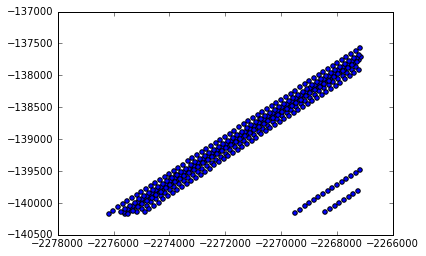

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(data['psx'], data['psy'])

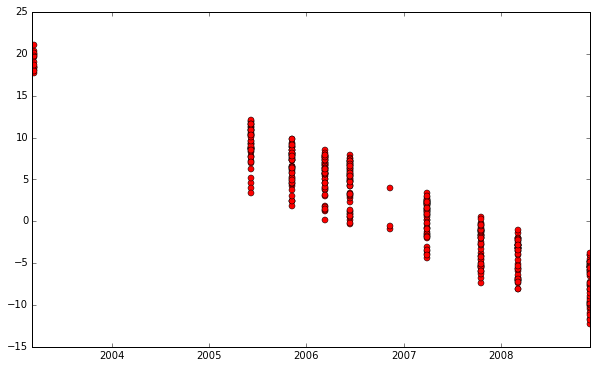

In [19]:
plt.figure(figsize=[10,6])
plt.plot(data['fltdate'], data['delta'], 'ro')

Wow, this looks like a nice linear trend.  Try fitting a linear model to the data.

In [20]:
data['days_since'] = (data.fltdate - pd.to_datetime('2003-01-01') ).astype('timedelta64[D]')
print data.days_since[0]

66.0


In [21]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(data.days_since, data.delta)

print slope*365., intercept, r_value * r_value, p_value, std_err

-4.73497344273 20.4556056597 0.905754999833 3.84820073564e-222 0.000202031843495


So we're looking at a surface drop of almost 5m/year!